# Subspace BNN

In [1]:
import jax
import einops
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import ticker
from sklearn.datasets import make_moons

In [2]:
from rebayes_mini import callbacks
from rebayes_mini.methods import kalman_filter as kf
from rebayes_mini.methods import subspace_filter as skf

## Drop-in replacement

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
plt.style.use("dark_background")

acolors = [
    "#D9117F",
    "#0DD9D9",
    "#F2A30F",
    "#F26E22",
]

colors = list(v["color"] for v in plt.rcParams["axes.prop_cycle"])

In [5]:
key = jax.random.PRNGKey(314)

In [6]:
n_samples = 500
n_test = 300
data = make_moons(n_samples=(n_samples + n_test), random_state=3141, noise=0.15)
X, y = jax.tree_map(jnp.array, data)
X_test, y_test = X[-n_test:], y[-n_test:]
X, y = X[:-n_test], y[:-n_test]

key = jax.random.PRNGKey(314)

In [7]:
%%time
@skf.subcify
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta


model = MLP(dim_in=2, dim_subspace=100)
params = model.init(key, X)

agent = skf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=2.0)
bel, bel_hist = agent.scan(bel_init, y, X, callbacks.get_updated_mean)
dim_full, _ = params["fixed"]["P"].shape

CPU times: user 4.09 s, sys: 78 ms, total: 4.16 s
Wall time: 3.19 s


In [8]:
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
(y_test == yhat.ravel()).mean()

Array(0.93333334, dtype=float32)

Text(0, 0.5, 'Weight value')

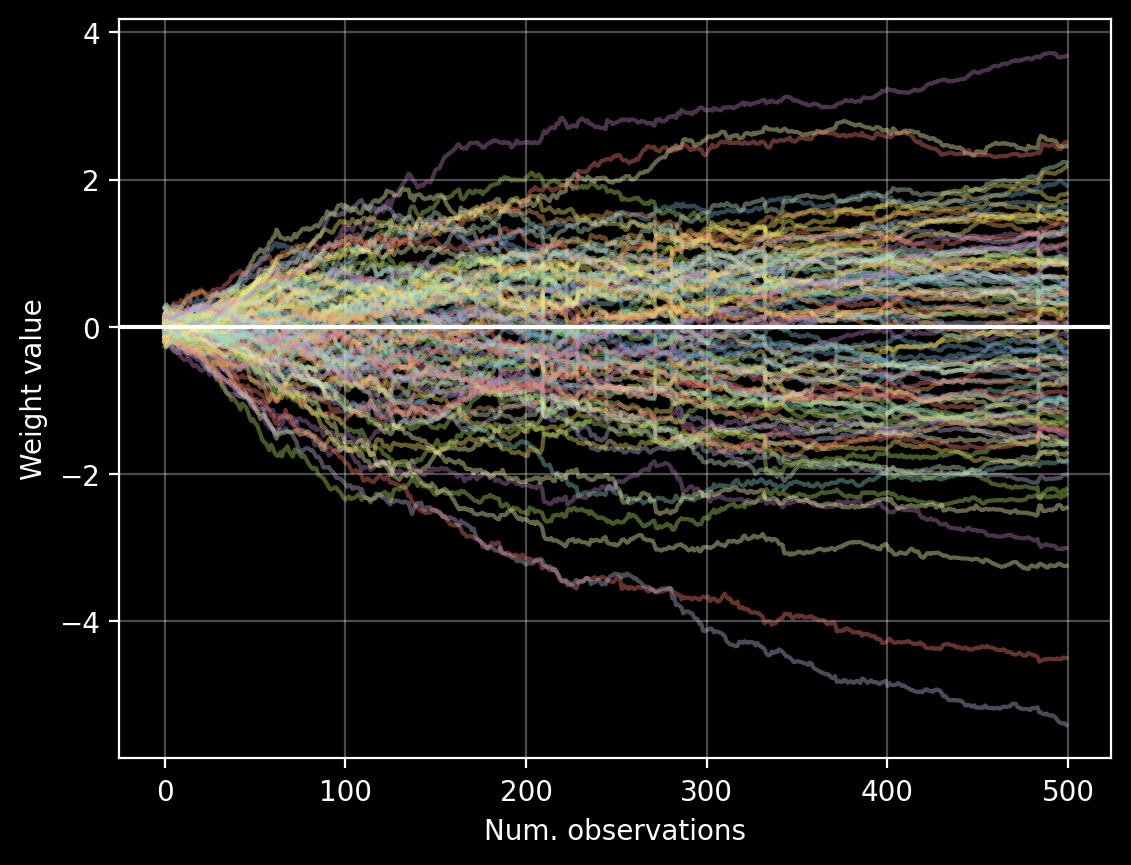

In [10]:
plt.plot(bel_hist, alpha=0.4)
plt.axhline(y=0, c="white")
plt.grid(alpha=0.3)
plt.xlabel("Num. observations")
plt.ylabel("Weight value")

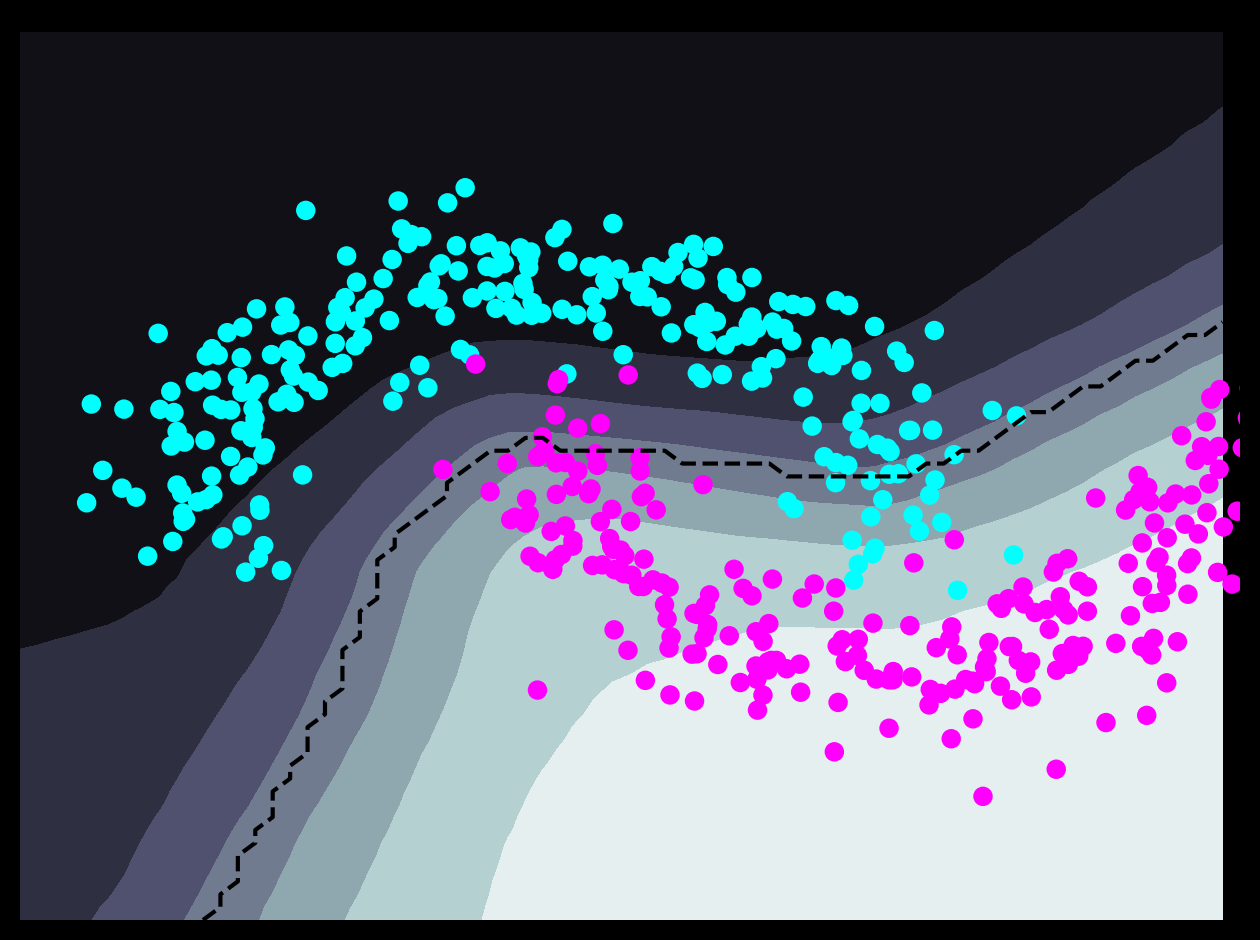

In [11]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Test accuracy as a function of subspace

In [12]:
%%time
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta


model = MLP()
params = model.init(key, X)

agent = kf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)
bel_init = agent.init_bel(params, cov=0.1)
bel, _ = agent.scan(bel_init, y, X)
bel = jax.block_until_ready(bel)

CPU times: user 3.94 s, sys: 67.4 ms, total: 4.01 s
Wall time: 6.66 s


In [13]:
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
acc_full = (y_test == yhat.ravel()).mean().item()
acc_full

0.9533333778381348

In [377]:
%%time
list_dim_subspace = np.arange(5, 155, 5)
SubMLP = skf.subcify(MLP)

n_runs = 15
results = []
keys = jax.random.split(key, n_runs)
for dim in tqdm(list_dim_subspace):
    model = SubMLP(dim_in=2, dim_subspace=dim)
    
    agent = skf.BernoulliFilter(
        model.apply,
        dynamics_covariance=0.0
    )
    
    @jax.vmap
    def eval_acc(key):
        params = model.init(key, X)
        bel_init = agent.init_bel(params, cov=2.0)
        bel, _ = agent.scan(bel_init, y, X)

        yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
        accuracy = (y_test == yhat.ravel()).mean()
        return accuracy
    
    accuracies = eval_acc(keys)
    results.append(accuracies)
results = pd.DataFrame(np.array(results), index=list_dim_subspace)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:41<00:00,  9.39s/it]


CPU times: user 6min 41s, sys: 4.07 s, total: 6min 45s
Wall time: 4min 42s


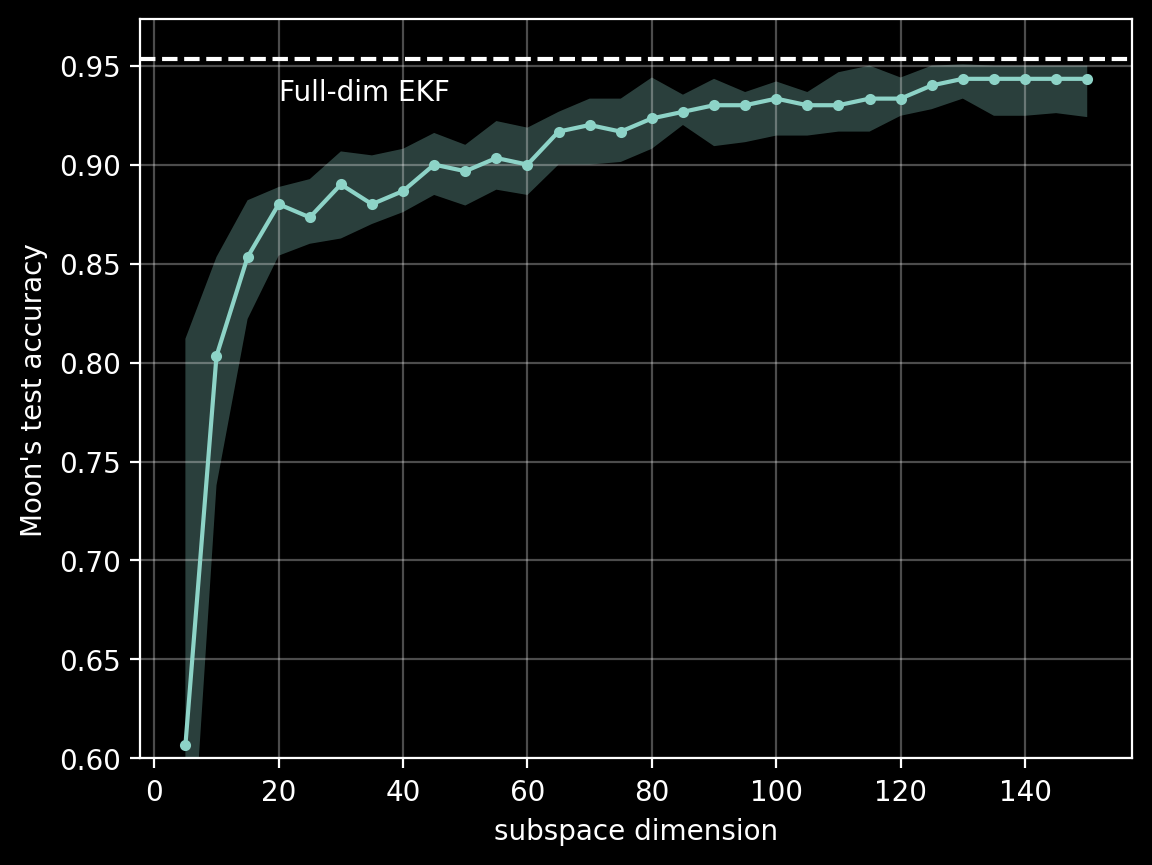

In [394]:
fig, ax = plt.subplots()

vmin = results.quantile(0.1, axis=1)
vmax = results.quantile(0.9, axis=1)

results.quantile(axis=1).plot(ax=ax, marker="o", markersize=3)
ax.fill_between(results.index, vmin, vmax, alpha=0.3)
ax.axhline(y=acc_full, linestyle="--")
ax.text(20, acc_full * (1 - 0.01), "Full-dim EKF", verticalalignment="top")

_, ymax = plt.ylim()
plt.ylim(0.6, ymax)

plt.xlabel("subspace dimension")
plt.ylabel("Moon's test accuracy")
plt.grid(alpha=0.3)

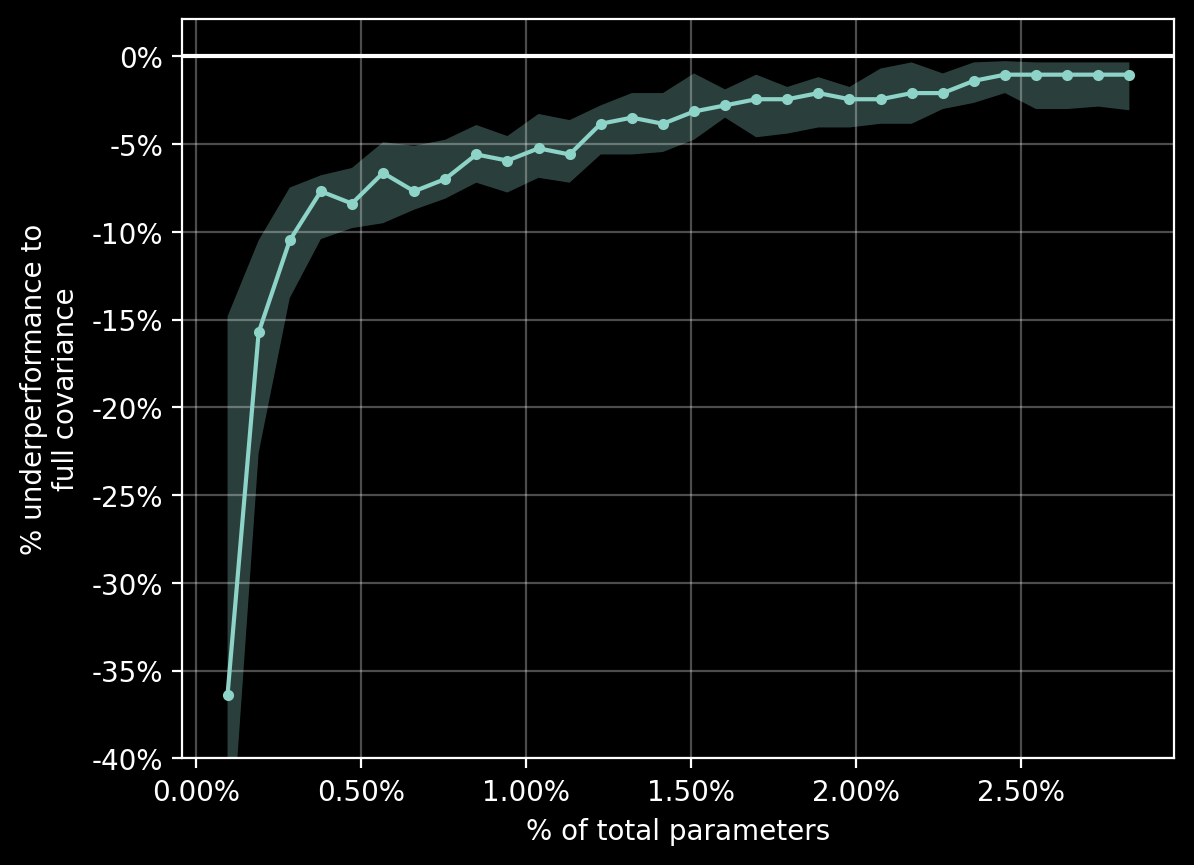

In [392]:
fig, ax = plt.subplots()

underperformance = results / acc_full - 1
underperformance.index = underperformance.index / dim_full
vmin = underperformance.quantile(0.1, axis=1)
vmax = underperformance.quantile(0.9, axis=1)

underperformance.quantile(axis=1).plot(ax=ax, marker="o", markersize=3)
ax.fill_between(underperformance.index, vmin, vmax, alpha=0.3)

_, ymax = plt.ylim()
plt.ylim(-0.4, ymax)

ax.axhline(y=0)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.2%}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))

plt.xlabel("% of total parameters")
plt.ylabel("% underperformance to\nfull covariance")
plt.grid(alpha=0.3)